In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
import pandas as pd
import numpy as np
import hyperopt
import time
import sklearn.metrics as mt
import pickle

from xgboost import Booster
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from itertools import chain

C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
#################################################################################################
###### The function load_window_dataset() that takes in input window data file, and 
###### label to be assigned and returns numpy arrays with features and labels
#################################################################################################

def load_window_dataset(X, y, filename, label):
#Inputs: - X: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only features)
#        - y: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only labels)
#        - filename: full name (with path) of the file to be read (it must be a window dataset file created above)
#        - label: integer, label to be assigned to the datapoints retrieved from filename; it may differ from labels already included in current y
#Outputs: - X: updated X (including features for the new data points retrieved from filename)
#         - y: updated y (including labels for the new data points)
#This function to X and y in input the new datapoints retrieved from filename and return updated X and y
#The function handle the case when X and y are empty (initialized as None)

    data = pd.read_csv(filename)
    
    if X is None:
        X = data.to_numpy()
        # full() function puts in all X.shape[0] elements the value "label"
        y = np.full(X.shape[0], label)
    else:
        X_temp = data.to_numpy()
        y_temp = np.full(X_temp.shape[0], label)
        X = np.append(X, X_temp, axis = 0) #F: axis=0-->stack X and X_temp vertically (increase no of rows)
        y = np.append(y, y_temp)

    return X, y

In [4]:
def train_classifier_XGB(X_train, y_train): 
    xgb = XGBClassifier(use_label_encoder=False, eta = 0.7, max_depth= 7, subsample = 1, verbosity = 0)

    # Execute the traning 3 times to be sure that the training time is correct
    ttimes = []
    for i in range(0, 3):
        t0 = time.time()
        xgb.fit(X_train, y_train)
        t1 = time.time()
        ex_time = t1 - t0
        ttimes.append(ex_time)
        print(ex_time)

    return xgb, ttimes

In [5]:
def train_classifier_DNN(X_train, y_train): 
    size = (50,) * 2
    dnn = MLPClassifier(hidden_layer_sizes=size, activation='tanh',
                        solver='adam', learning_rate='invscaling', max_iter=1000)

    # Execute the traning 3 times to be sure that the training time is correct
    ttimes = []
    for i in range(0, 3):
        t0 = time.time()
        dnn.fit(X_train, y_train)
        t1 = time.time()
        ex_time = t1 - t0
        ttimes.append(ex_time)
        print(ex_time)

    return dnn, ttimes

In [6]:
def train_classifier_KNN(X_train, y_train): 
    knn = KNeighborsClassifier(leaf_size=43, p=1, n_neighbors=14)

    # Execute the traning 3 times to be sure that the training time is correct
    ttimes = []
    for i in range(0, 3):
        t0 = time.time()
        knn.fit(X_train, y_train)
        t1 = time.time()
        ex_time = t1 - t0
        ttimes.append(ex_time)
        print(ex_time)

    return knn, ttimes

In [7]:
########################################################################################################
###### The function performance_eval() takes in input ground truth and predicted labels, 
###### prints results in a result file passed in input, and returns global metrics
########################################################################################################

def performance_eval(y_true, y_pred, lab, l_names):

    #Compute metrics and print/write them
    accuracy = mt.accuracy_score(y_true, y_pred)
    precision = mt.precision_score(y_true, y_pred, labels=lab, average=None) #F: average=None gives per-class results
    global_precision = mt.precision_score(y_true, y_pred, labels=lab, average='weighted') 
    recall = mt.recall_score(y_true, y_pred, labels=lab, average=None)
    global_recall = mt.recall_score(y_true, y_pred, labels=lab, average='weighted') 
    f1score = mt.f1_score(y_true, y_pred, labels=lab, average=None)
    global_f1score = mt.f1_score(y_true, y_pred, labels=lab, average='weighted')

    return accuracy, global_precision, global_recall, global_f1score 

In [8]:
windowrange=[3, 5, 10, 30, 75, 150, 300, 750, 1200, 1800, 3600]
spacingrange=[3, 5, 10, 30, 75, 150, 300, 750, 1200, 1800, 3600]

A_XGB = np.zeros([len(spacingrange),len(windowrange)])
GP_XGB = np.zeros([len(spacingrange),len(windowrange)])
GR_XGB = np.zeros([len(spacingrange),len(windowrange)])
GF1_XGB = np.zeros([len(spacingrange),len(windowrange)])

A_DNN = np.zeros([len(spacingrange),len(windowrange)])
GP_DNN = np.zeros([len(spacingrange),len(windowrange)])
GR_DNN = np.zeros([len(spacingrange),len(windowrange)])
GF1_DNN = np.zeros([len(spacingrange),len(windowrange)])

A_KNN = np.zeros([len(spacingrange),len(windowrange)])
GP_KNN = np.zeros([len(spacingrange),len(windowrange)])
GR_KNN = np.zeros([len(spacingrange),len(windowrange)])
GF1_KNN = np.zeros([len(spacingrange),len(windowrange)])

def training_loop(windowrange, spacingrange):
    global A_XGB, GP_XGB, GR_XGB, GF1_XGB
    global A_DNN, GP_DNN, GR_DNN, GF1_DNN
    global A_KNN, GP_KNN, GR_KNN, GF1_KNN
    
    xgb_all_ttimes = []
    dnn_all_ttimes = []
    knn_all_ttimes = []
    
    lbl = [0, 1]
    label_names=['Attenuation', 'Filtering']

    for i, spacing in enumerate(spacingrange): #enumerate(range(minsp,maxsp+1,stepsp)):
        for j, length in enumerate(windowrange): #enumerate(range(minlength,maxlength+1,steplength)):
            print('********************************')
            print('Iteration for spacing={} and window length={}'.format(spacing,length))

            ####### 1) Load dataset #######
            print('1) Loading dataset into (XX,yy)...')

            XX = None
            yy = None
            folderpath='../Features_raw'

            for filename in os.listdir(folderpath):
                if filename.endswith('_sp' + str(spacing) + '_w' + str(length) + '.dat'):
                    label = 0
                    if int(filename[9]) > 5:
                        label = 1
                    fullname = folderpath + '/' + filename
                    XX, yy = load_window_dataset(XX, yy, fullname, label)

            scaler = StandardScaler()
            XX = scaler.fit_transform(XX)

            X_train, X_test, y_train, y_test = train_test_split(XX, yy, stratify=yy, test_size=0.3, random_state=42)
            print('Training XGB...')
            xgb, xgb_ttimes = train_classifier_XGB(X_train, y_train)

            print('Training DNN...')
            dnn, dnn_ttimes = train_classifier_DNN(X_train, y_train)

            print('Training KNN...')
            knn, knn_ttimes = train_classifier_KNN(X_train, y_train)

            xgb_all_ttimes.append(xgb_ttimes)
            dnn_all_ttimes.append(dnn_ttimes)
            knn_all_ttimes.append(knn_ttimes)

            y_pred_XGB = xgb.predict(X_test)
            y_pred_DNN = dnn.predict(X_test)
            y_pred_KNN = knn.predict(X_test)

            A_XGB[i,j], GP_XGB[i,j], GR_XGB[i,j], GF1_XGB[i,j] = performance_eval(y_test, y_pred_XGB, lbl, label_names)
            A_DNN[i,j], GP_DNN[i,j], GR_DNN[i,j], GF1_DNN[i,j] = performance_eval(y_test, y_pred_DNN, lbl, label_names)
            A_KNN[i,j], GP_KNN[i,j], GR_KNN[i,j], GF1_KNN[i,j] = performance_eval(y_test, y_pred_KNN, lbl, label_names)

    return xgb_all_ttimes, dnn_all_ttimes, knn_all_ttimes

In [9]:
fig_folder = '1_7_Figures'
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

xgb_all_ttimes, dnn_all_ttimes, knn_all_ttimes = training_loop(windowrange, spacingrange)

********************************
Iteration for spacing=3 and window length=3
1) Loading dataset into (XX,yy)...
Training XGB...
5.3611860275268555
5.52120304107666
5.780309438705444
Training DNN...
24.41974639892578
8.415812015533447
18.35714101791382
Training KNN...
0.03432512283325195
0.036002159118652344
0.033559322357177734
********************************
Iteration for spacing=3 and window length=5
1) Loading dataset into (XX,yy)...
Training XGB...
5.628942251205444
5.259366035461426
5.283212184906006
Training DNN...
9.86419415473938
7.673367977142334
9.872148513793945
Training KNN...
0.034993648529052734
0.03159594535827637
0.038002729415893555
********************************
Iteration for spacing=3 and window length=10
1) Loading dataset into (XX,yy)...
Training XGB...
3.5011162757873535
3.636314630508423
3.6697580814361572
Training DNN...
6.2575905323028564
6.824256181716919
7.175174951553345
Training KNN...
0.032517433166503906
0.03512740135192871
0.03500103950500488
********

4.669644117355347
3.808861255645752
4.097317934036255
Training KNN...
0.012432098388671875
0.010717391967773438
0.010000228881835938
********************************
Iteration for spacing=10 and window length=30
1) Loading dataset into (XX,yy)...
Training XGB...
0.6708228588104248
0.6693456172943115
0.6870174407958984
Training DNN...
3.7696874141693115
3.980091094970703
3.4663021564483643
Training KNN...
0.011006832122802734
0.013809680938720703
0.01449131965637207
********************************
Iteration for spacing=10 and window length=75
1) Loading dataset into (XX,yy)...
Training XGB...
0.6099162101745605
0.6235778331756592
0.6228530406951904
Training DNN...
4.242426156997681
3.803933620452881
4.2927117347717285
Training KNN...
0.010997772216796875
0.010997533798217773
0.010004520416259766
********************************
Iteration for spacing=10 and window length=150
1) Loading dataset into (XX,yy)...
Training XGB...
0.5937561988830566
0.6150527000427246
0.6082725524902344
Train

Training XGB...
0.12347531318664551
0.1345672607421875
0.13242769241333008
Training DNN...
1.4831461906433105
1.7053782939910889
1.7070753574371338
Training KNN...
0.0019974708557128906
0.002999544143676758
0.0019998550415039062
********************************
Iteration for spacing=75 and window length=300
1) Loading dataset into (XX,yy)...
Training XGB...
0.12204289436340332
0.13049769401550293
0.13827133178710938
Training DNN...
1.8645987510681152
1.5540363788604736
1.7113738059997559
Training KNN...
0.0030035972595214844
0.0019981861114501953
0.003010272979736328
********************************
Iteration for spacing=75 and window length=750
1) Loading dataset into (XX,yy)...
Training XGB...
0.1133270263671875
0.12430930137634277
0.12244772911071777
Training DNN...
1.5298640727996826
1.2414371967315674
1.4586331844329834
Training KNN...
0.003004312515258789
0.0019989013671875
0.0030002593994140625
********************************
Iteration for spacing=75 and window length=1200
1) L

Training XGB...
0.06451916694641113
0.07950234413146973
0.0755164623260498
Training DNN...
0.8032965660095215
0.9256818294525146
0.8353886604309082
Training KNN...
0.0009531974792480469
0.002000570297241211
0.00099945068359375
********************************
Iteration for spacing=300 and window length=1200
1) Loading dataset into (XX,yy)...
Training XGB...
0.061563730239868164
0.0760190486907959
0.07592344284057617
Training DNN...
0.9172940254211426
0.7833313941955566
0.997551679611206
Training KNN...
0.002044677734375
0.0009813308715820312
0.001970052719116211
********************************
Iteration for spacing=300 and window length=1800
1) Loading dataset into (XX,yy)...
Training XGB...
0.06593823432922363
0.07295036315917969
0.07256674766540527
Training DNN...
0.8841817378997803
0.8464264869689941
0.8245556354522705
Training KNN...
0.001994609832763672
0.001001119613647461
0.0010001659393310547
********************************
Iteration for spacing=300 and window length=3600
1) 

C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


1.1160147190093994
0.9530012607574463
Training KNN...
0.001007080078125
0.0010409355163574219
0.0009586811065673828
********************************
Iteration for spacing=1200 and window length=5
1) Loading dataset into (XX,yy)...
Training XGB...
0.04725503921508789
0.061220645904541016
0.06350255012512207
Training DNN...


C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


1.1498610973358154
0.8086321353912354
0.9120316505432129
Training KNN...
0.0009644031524658203
0.0010106563568115234
0.0009999275207519531
********************************
Iteration for spacing=1200 and window length=10
1) Loading dataset into (XX,yy)...
Training XGB...
0.04699420928955078
0.05951642990112305
0.06136441230773926
Training DNN...
0.7305519580841064
0.6481831073760986
0.77701735496521
Training KNN...
0.00099945068359375
0.0009980201721191406
0.0009982585906982422
********************************
Iteration for spacing=1200 and window length=30
1) Loading dataset into (XX,yy)...
Training XGB...
0.045496225357055664
0.06146860122680664
0.06161165237426758
Training DNN...
0.7623698711395264
0.880720853805542
0.6309075355529785
Training KNN...
0.002002239227294922
0.0010030269622802734
0.0
********************************
Iteration for spacing=1200 and window length=75
1) Loading dataset into (XX,yy)...
Training XGB...
0.04494595527648926
0.06154227256774902
0.0627179145812988

C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.6304221153259277
Training KNN...
0.001979827880859375
0.0
0.0009801387786865234
********************************
Iteration for spacing=1800 and window length=5
1) Loading dataset into (XX,yy)...
Training XGB...
0.04449343681335449
0.056449174880981445
0.05666494369506836
Training DNN...


C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.6636338233947754


C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.6138489246368408
0.5556256771087646
Training KNN...
0.0010013580322265625
0.0009520053863525391
0.0010006427764892578
********************************
Iteration for spacing=1800 and window length=10
1) Loading dataset into (XX,yy)...
Training XGB...
0.04450345039367676
0.059720754623413086
0.05898308753967285
Training DNN...
0.6628575325012207
0.49434900283813477


C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.6275804042816162
Training KNN...
0.001621246337890625
0.0010075569152832031
0.0010001659393310547
********************************
Iteration for spacing=1800 and window length=30
1) Loading dataset into (XX,yy)...
Training XGB...
0.047139883041381836
0.05753159523010254
0.0599365234375
Training DNN...


C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.6682589054107666
0.00999307632446289
0.5363197326660156
Training KNN...
0.0019998550415039062
0.0
0.0009996891021728516
********************************
Iteration for spacing=1800 and window length=75
1) Loading dataset into (XX,yy)...
Training XGB...
0.04315805435180664
0.05721712112426758
0.06038713455200195
Training DNN...


C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.6868538856506348
0.047043800354003906


C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.6315858364105225
Training KNN...
0.0016396045684814453
0.0010831356048583984
0.0010421276092529297
********************************
Iteration for spacing=1800 and window length=150
1) Loading dataset into (XX,yy)...
Training XGB...
0.04700136184692383
0.0571444034576416
0.05599045753479004
Training DNN...
0.0672600269317627
0.05551886558532715
0.03911542892456055
Training KNN...
0.0009989738464355469
0.0010013580322265625
0.0009999275207519531
********************************
Iteration for spacing=1800 and window length=300
1) Loading dataset into (XX,yy)...


C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training XGB...
0.04264092445373535
0.059644222259521484
0.058411598205566406
Training DNN...
0.594994306564331
0.4957590103149414
0.514946460723877
Training KNN...
0.0005052089691162109
0.0010066032409667969
0.0013713836669921875
********************************
Iteration for spacing=1800 and window length=750
1) Loading dataset into (XX,yy)...
Training XGB...
0.04513692855834961
0.056519508361816406
0.057898521423339844
Training DNN...
0.513526439666748
0.04720640182495117
0.5351095199584961
Training KNN...
0.0009548664093017578
0.0009996891021728516
0.0009996891021728516
********************************
Iteration for spacing=1800 and window length=1200
1) Loading dataset into (XX,yy)...
Training XGB...
0.045084476470947266
0.058670997619628906
0.05785417556762695
Training DNN...
0.05800795555114746


C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6352620124816895
0.03201007843017578
Training KNN...
0.0010001659393310547
0.0010020732879638672
0.0009980201721191406
********************************
Iteration for spacing=1800 and window length=1800
1) Loading dataset into (XX,yy)...
Training XGB...
0.0449678897857666
0.059508562088012695
0.05866837501525879
Training DNN...
0.09554076194763184


C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6309487819671631
0.01599431037902832
Training KNN...
0.002000570297241211
0.0009987354278564453
0.0
********************************
Iteration for spacing=1800 and window length=3600
1) Loading dataset into (XX,yy)...
Training XGB...
0.04674959182739258
0.05727720260620117
0.058650970458984375
Training DNN...
0.5873744487762451


C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.602036714553833
0.04082798957824707
Training KNN...
0.0009996891021728516
0.0010006427764892578
0.0009996891021728516
********************************
Iteration for spacing=3600 and window length=3
1) Loading dataset into (XX,yy)...
Training XGB...
0.03973746299743652
0.0546422004699707
0.055006980895996094
Training DNN...
0.6298081874847412


C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.563730001449585
0.03266429901123047
Training KNN...
0.0009989738464355469
0.0
0.0015811920166015625
********************************
Iteration for spacing=3600 and window length=5
1) Loading dataset into (XX,yy)...
Training XGB...
0.043001651763916016
0.05281400680541992
0.05510568618774414
Training DNN...
0.06016254425048828


C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.6006557941436768


C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.55985426902771
Training KNN...
0.0010006427764892578
0.0009999275207519531
0.0015883445739746094
********************************
Iteration for spacing=3600 and window length=10
1) Loading dataset into (XX,yy)...
Training XGB...
0.05109882354736328
0.05860543251037598
0.05711674690246582
Training DNN...
0.5358350276947021
0.019849300384521484
0.5368978977203369
Training KNN...
0.0009605884552001953
0.0009987354278564453
0.0009984970092773438
********************************
Iteration for spacing=3600 and window length=30
1) Loading dataset into (XX,yy)...
Training XGB...
0.043567657470703125
0.05588197708129883
0.05762958526611328
Training DNN...


C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.6107654571533203
0.5326504707336426
0.5246429443359375
Training KNN...
0.001003265380859375
0.0010256767272949219
0.0010144710540771484
********************************
Iteration for spacing=3600 and window length=75
1) Loading dataset into (XX,yy)...
Training XGB...
0.04098367691040039
0.05500030517578125
0.054694414138793945
Training DNN...
0.6206424236297607
0.5757806301116943
0.49683189392089844
Training KNN...
0.0009562969207763672
0.0010461807250976562
0.0010077953338623047
********************************
Iteration for spacing=3600 and window length=150
1) Loading dataset into (XX,yy)...
Training XGB...
0.04300093650817871
0.05827474594116211
0.05600094795227051
Training DNN...
0.4653775691986084
0.032996177673339844
0.4532341957092285
Training KNN...
0.0010001659393310547
0.0010008811950683594
0.0
********************************
Iteration for spacing=3600 and window length=300
1) Loading dataset into (XX,yy)...
Training XGB...
0.043953895568847656
0.07646608352661133
0.05523

C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training XGB...
0.04011368751525879
0.054619789123535156
0.05398082733154297
Training DNN...


C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.5986602306365967
0.4638383388519287
0.3918330669403076
Training KNN...
0.0010013580322265625
0.0010030269622802734
0.0
********************************
Iteration for spacing=3600 and window length=1800
1) Loading dataset into (XX,yy)...
Training XGB...
0.041516780853271484
0.05707836151123047
0.05775856971740723
Training DNN...
0.6385648250579834
0.376934289932251
0.42473936080932617
Training KNN...
0.0010030269622802734
0.0009543895721435547
0.0020012855529785156
********************************
Iteration for spacing=3600 and window length=3600
1) Loading dataset into (XX,yy)...
Training XGB...
0.03908371925354004
0.05560898780822754
0.05777382850646973
Training DNN...
0.05500006675720215
0.058968544006347656
0.42955851554870605
Training KNN...
0.0020151138305664062
0.0
0.0009882450103759766


In [82]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    ax.set_xlabel('Window')
    ax.set_ylabel('Spacing')
    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


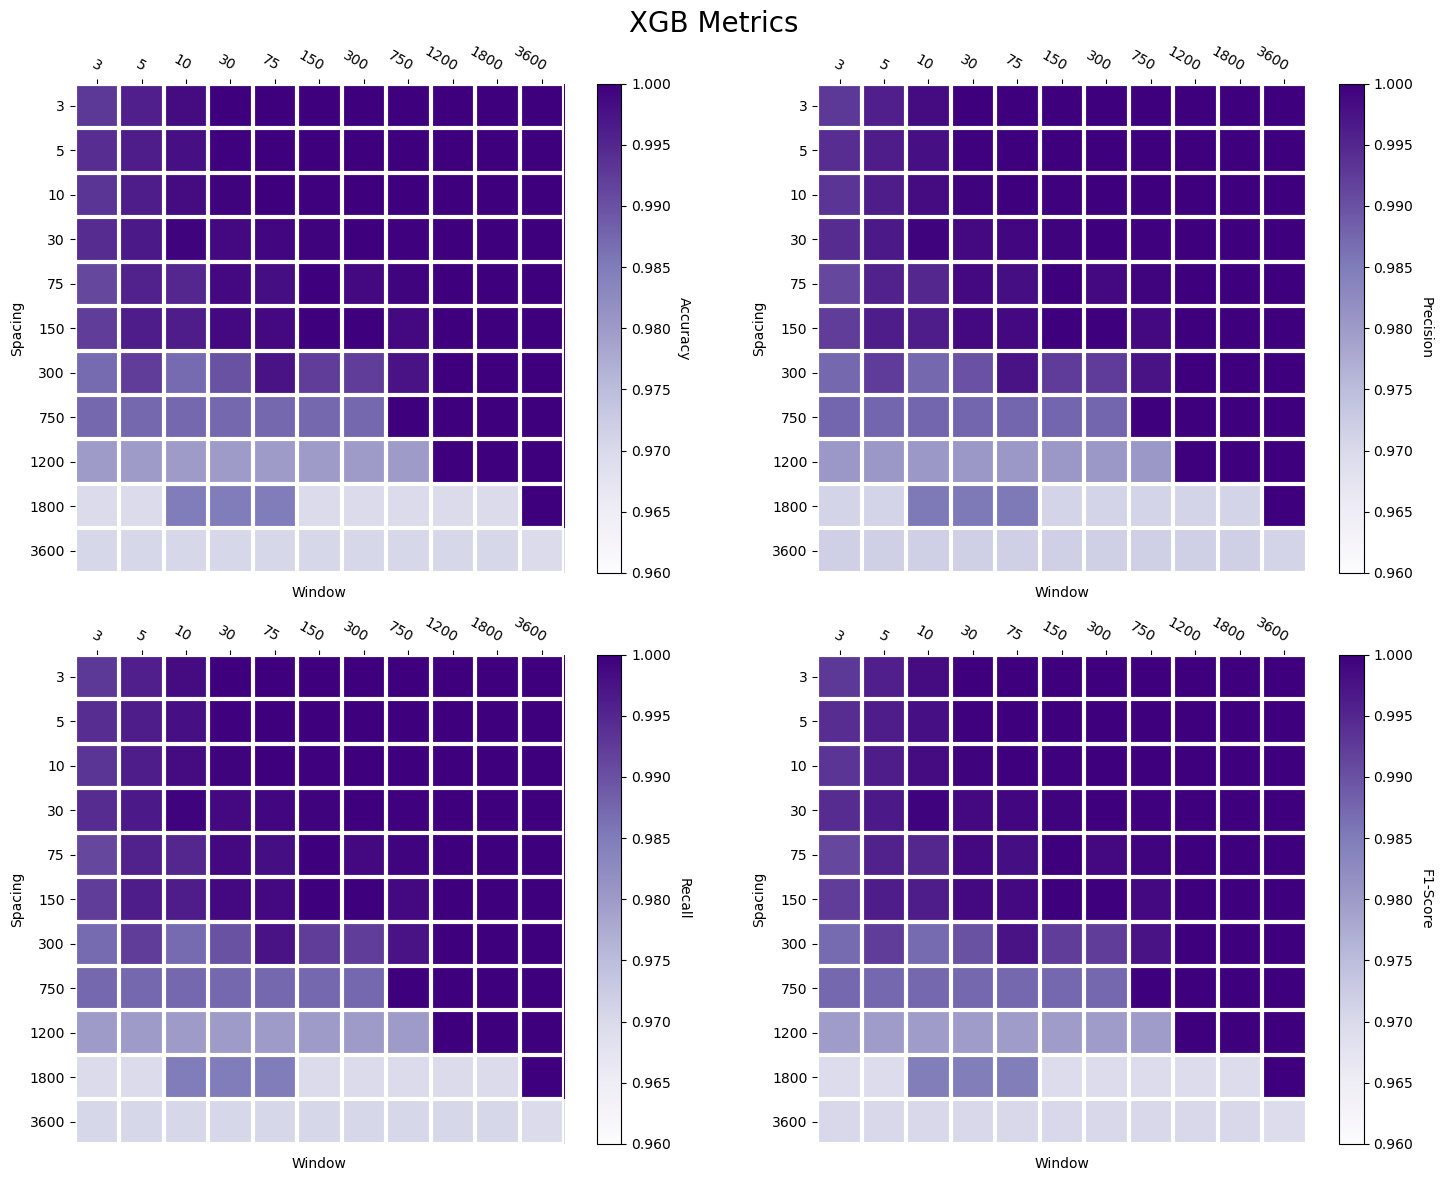

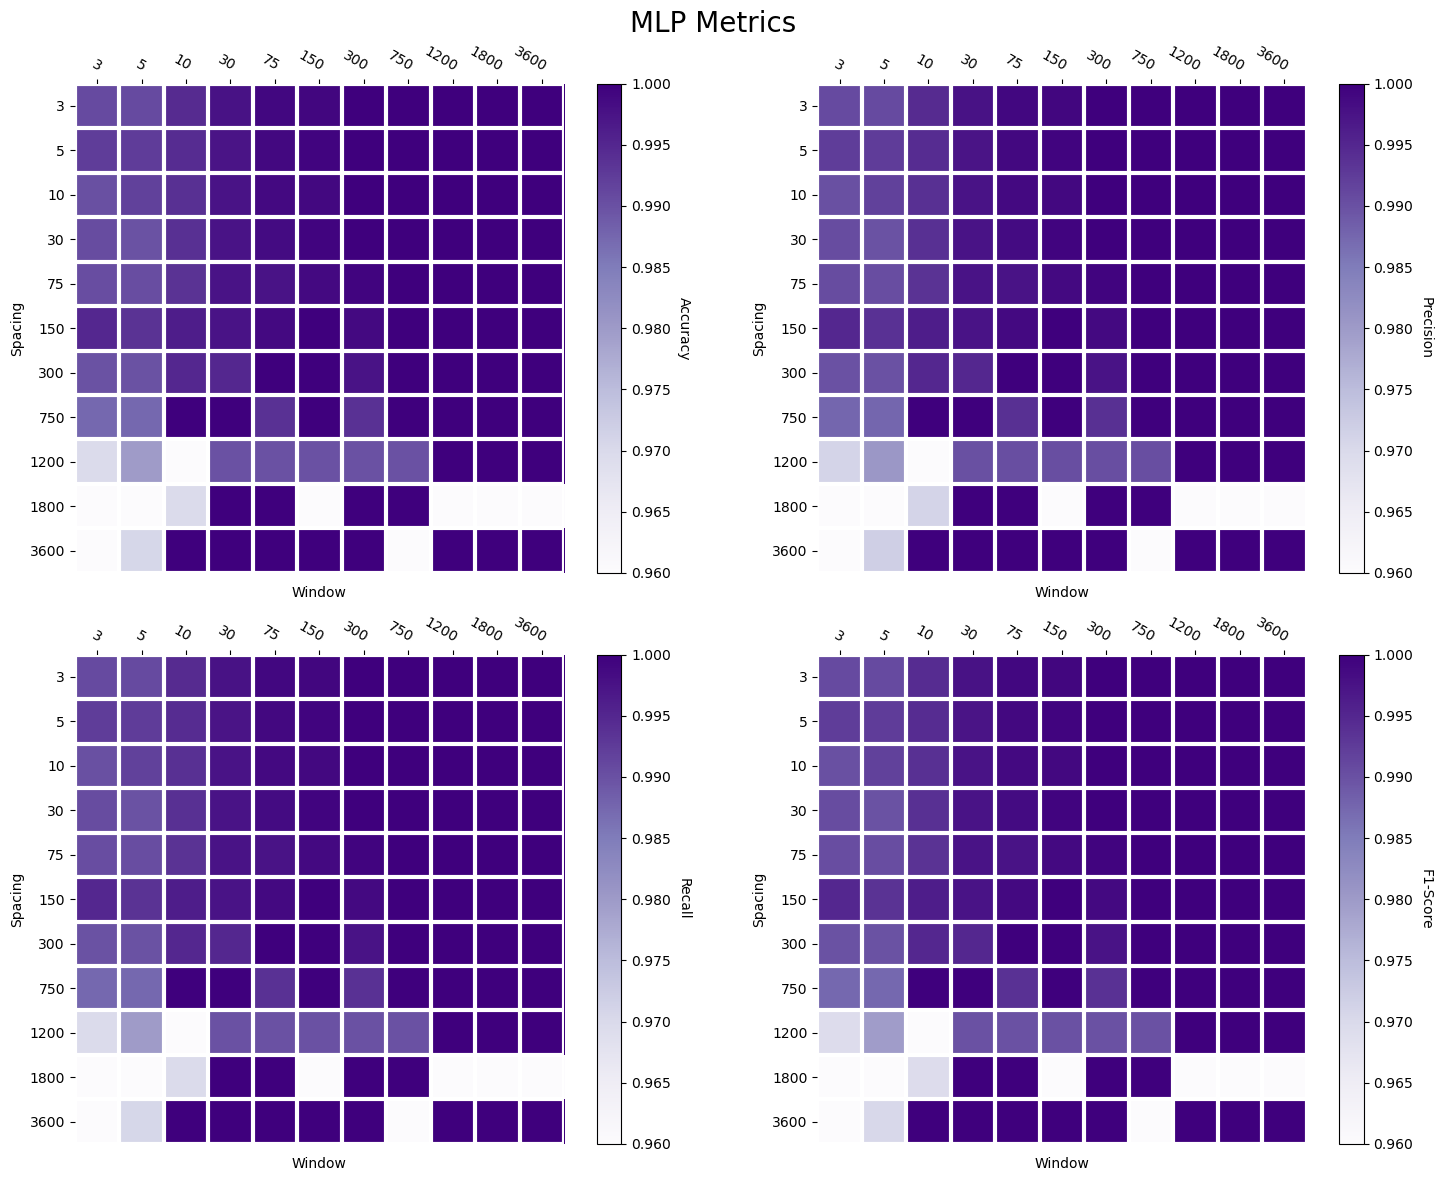

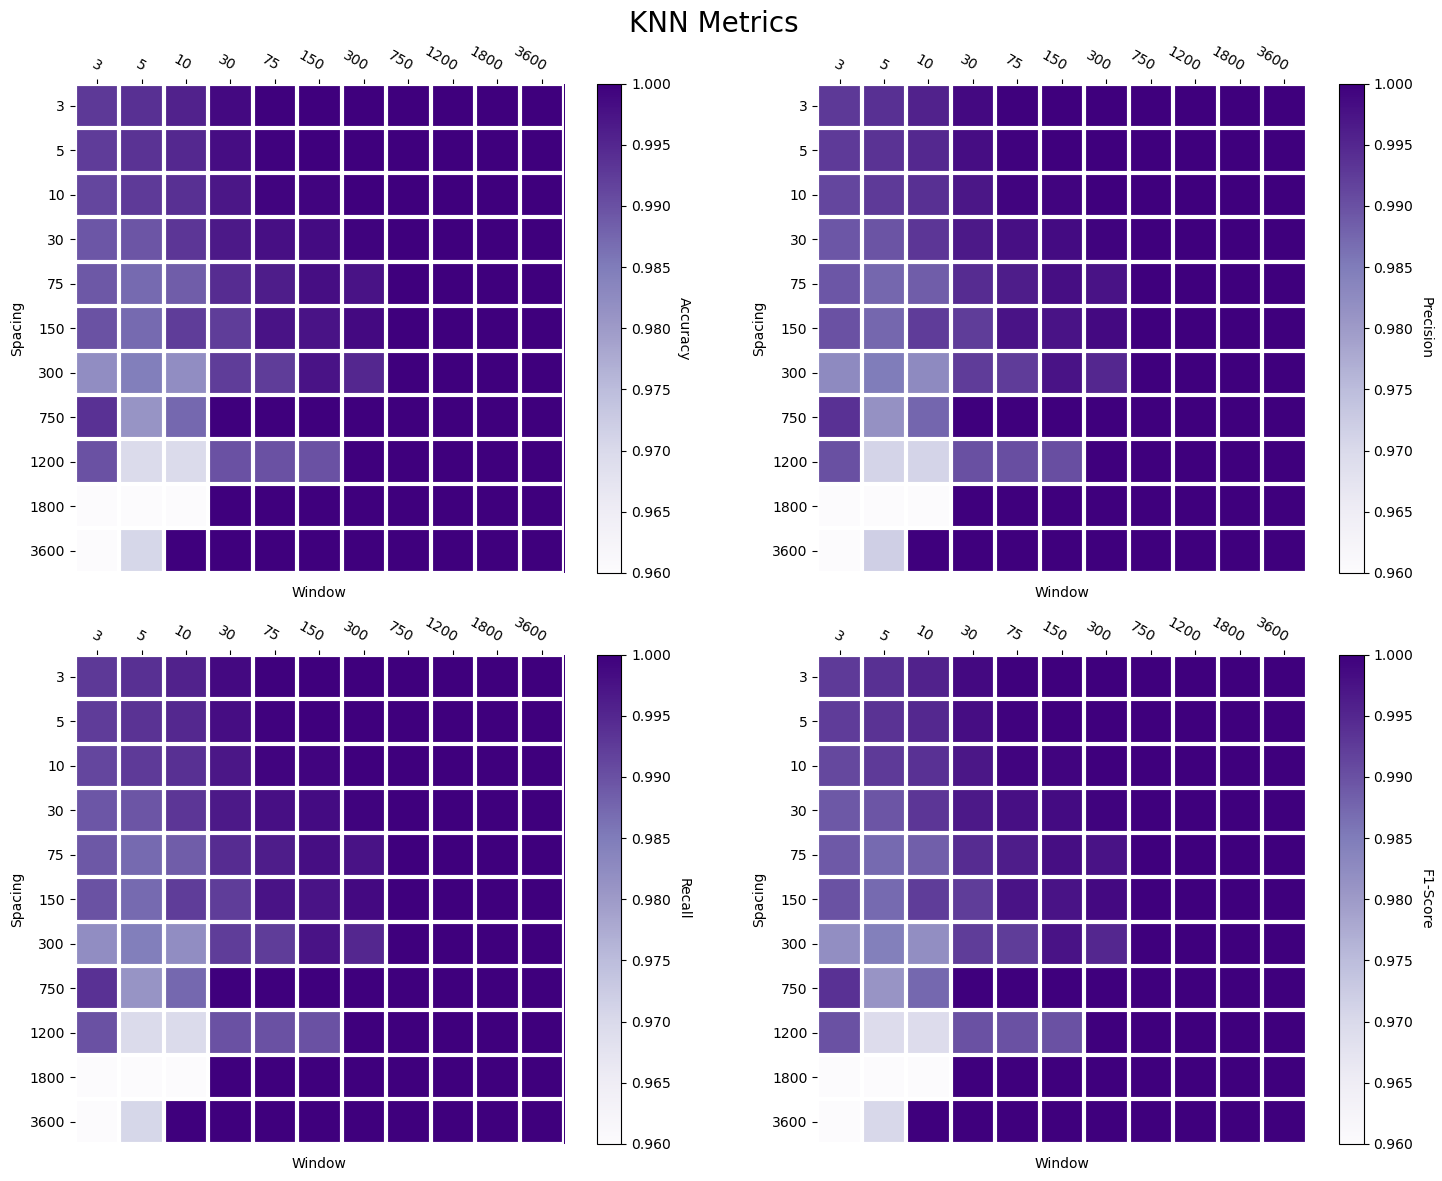

In [88]:
str_window_range = [str(x) for x in windowrange]
str_spacing_range = [str(x) for x in spacingrange]

alg_names = ['XGB', 'MLP', 'KNN']

A_mat = [A_XGB, A_DNN, A_KNN]
GP_mat = [GP_XGB, GP_DNN, GP_KNN]
GR_mat = [GR_XGB, GR_DNN, GR_KNN]
GF1_mat = [GF1_XGB, GF1_DNN, GF1_KNN]

for i in range(0, 3):
    fig, ((ax, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,12))

    im, _ = heatmap(A_mat[i], str_spacing_range, str_window_range, ax=ax,
                    cmap="Purples", cbarlabel="Accuracy", vmin=0.96, vmax=1)

    im, _ = heatmap(GP_mat[i], str_spacing_range, str_window_range, ax=ax2,
                    cmap="Purples", cbarlabel="Precision", vmin=0.96, vmax=1)

    im, _ = heatmap(GR_mat[i], str_spacing_range, str_window_range, ax=ax3,
                    cmap="Purples", cbarlabel="Recall", vmin=0.96, vmax=1)

    im, _ = heatmap(GF1_mat[i], str_spacing_range, str_window_range, ax=ax4,
                    cmap="Purples", cbarlabel="F1-Score", vmin=0.96, vmax=1)

    title = alg_names[i] + " Metrics"
    fig.suptitle(title, fontsize=20)
    fig.savefig(fig_folder+'/'+title.replace(" ", "_")+'.png')
    plt.tight_layout()
    plt.show()

In [59]:
all_ttimes = [xgb_all_ttimes, dnn_all_ttimes, knn_all_ttimes]

xgb_all_ttimes_mean = []
dnn_all_ttimes_mean = []
knn_all_ttimes_mean = []
    
all_ttimes_mean = [xgb_all_ttimes_mean, dnn_all_ttimes_mean, knn_all_ttimes_mean]

for ttimes in xgb_all_ttimes:
    xgb_all_ttimes_mean.append(sum(ttimes)/len(ttimes))

for ttimes in dnn_all_ttimes:
    dnn_all_ttimes_mean.append(sum(ttimes)/len(ttimes))
    
for ttimes in knn_all_ttimes:
    knn_all_ttimes_mean.append(sum(ttimes)/len(ttimes))

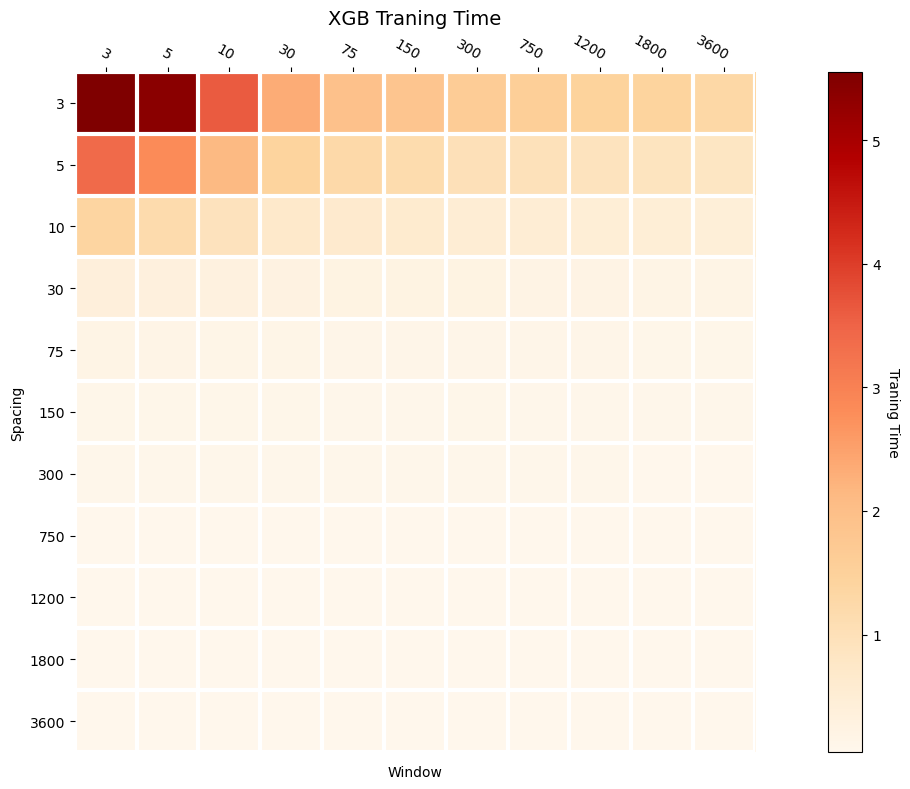

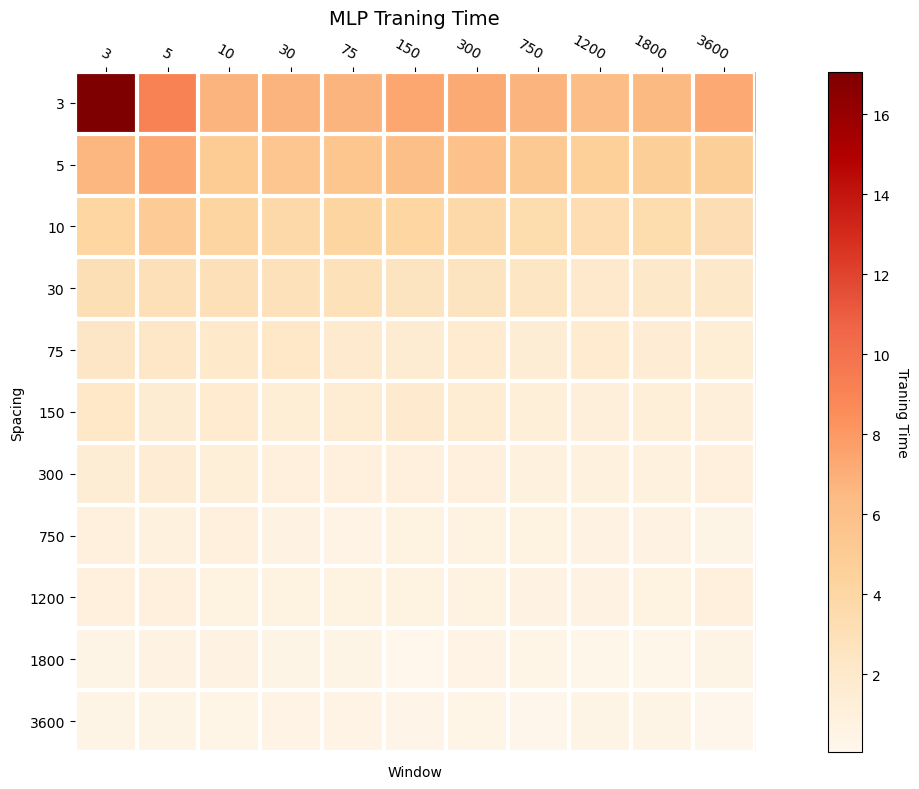

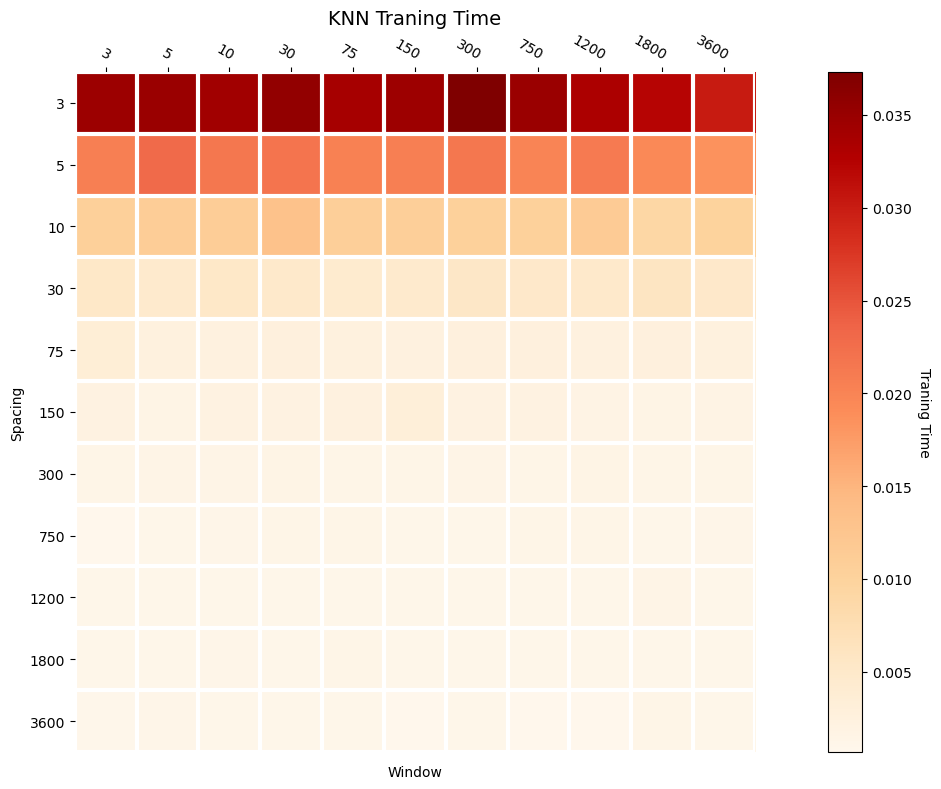

In [84]:
all_times_mat = []

for alg_all_ttimes in all_ttimes_mean:
    mat = []
    while alg_all_ttimes != []:
        mat.append(alg_all_ttimes[:len(windowrange)])
        alg_all_ttimes = alg_all_ttimes[len(windowrange):]
    mat = np.array(mat)
    all_times_mat.append(mat)

for i in range(0, 3):
    fig, ax = plt.subplots(figsize=(15,8))
    title = alg_names[i] + " Traning Time"
    im, cbar = heatmap(all_times_mat[i], str_spacing_range, str_window_range, ax=ax,
                       cmap="OrRd", cbarlabel="Traning Time")
    
    plt.title(title, fontsize=14)
    fig.tight_layout()
    fig.savefig(fig_folder+'/'+title.replace(" ", "_")+'.png')                       
    plt.show()
